<a href="https://colab.research.google.com/github/thad75/TP_ENSEA_ELEVE/blob/main/3A/SIA/TP3/Self_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning
!pip install wandb

USE_COLAB = True
CONTENT_DIR = "/content" if USE_COLAB else "."

import wandb
if not wandb.login():
    raise ValueError("WandDB authentification failed.")

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import torchmetrics
import torchvision.transforms as transforms
import os
import glob
import cv2
from torch.utils.data import Dataset, Subset, DataLoader
import random
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(42)
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10
from torchvision.datasets import SVHN as torch_SVHN
from torchvision.models import resnet18, resnet50
from torchvision.datasets.utils import extract_archive
from pytorch_lightning.loggers import WandbLogger
import cv2 as cv

import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer

def imshow(img):
    if isinstance(img, torch.Tensor):
        img = np.moveaxis(img.detach().cpu().numpy(), 0, -1)
    plt.axis("off")
    plt.imshow(img)
    plt.show()

<center><h1> Self Supervised Learning</h1></center>

<div Align= 'justify'>In all of the previous classification tasks, we had a high amount of labeled images for each classes. This allows our model to properly learn and generally achieve good accuracy given enough images. However, we often **don't have access** to a high amount of labeled data; but only a **small set of labeled data** and a bigger set of unlabeled data.

Therefore, we would be interested in a learning strategy that would enable us to **extract useful information from the unlabeled image** set for a simpler representations (Representation Learning) and then use the labeled samples to learn a classifier on these representations (Fine-tunning Classification). One simple yet successful approach has been the use of pretext tasks. **Pretext tasks** learning consists in considering an **auxiliary task**, different from our target task, and learn a network by solving this task. Then, we only keep part of the network as a representation encoder. The full process is summarized bellow: </div>


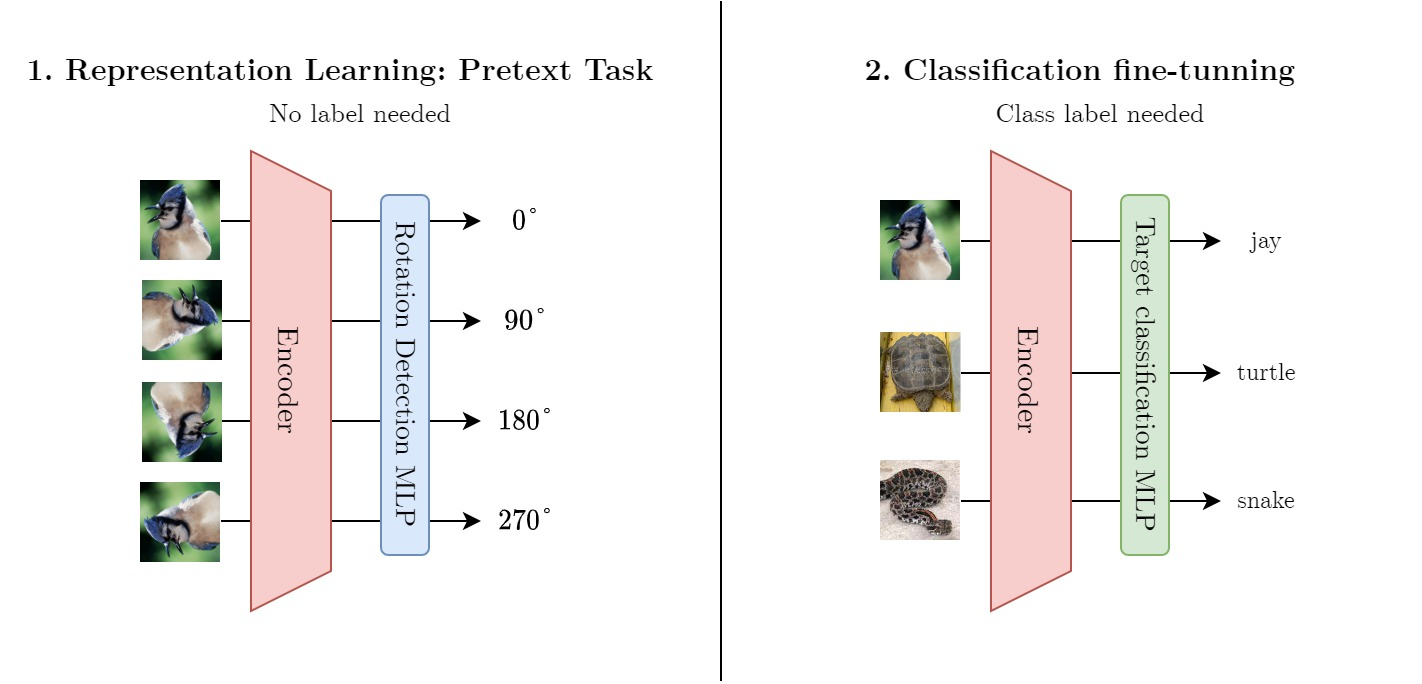


Pretext tasks are a part of self-supervised learning methods that formulate a supervised learning scheme from unlabeled data.


**Goal of this lab** :
* Understand how representation learning through pretext tasks works
* Practice fine-tuning
* Overview some other applications of pretext tasks
* Reuse Pytorch Lightning

# I - Industrial Task 1 : Classifying street number with few labeled data

<div Align="justify">Let imagine that you want to recognize street numbers from street view imagery. Since you have free access to many street photos containing street numbers, you can obtain a huge amount of pictures of street numbers (let put aside how you extract and isolate them from full street images). However, you don't have the label (number) information for each of these images. Consequently, you painstakingly go over the first 1000 images and manually label them. Tools like LabelImg, CVAT are your best friends for a while..</div>


<div Align="justify">You are in a semi-supervised setting where you have access to a high amount of street number images but only 1% of labeled data.

In this first part you will evaluate **how pretext tasks can be applied to help you leverage the informations in the unlabeled set to achieve good classification performances.** </div>

## 1 - Street View House Numbers

To reproduce the aformentionned scenario, we will be using the Street View House Numbers (SVHN) dataset, and remove 99% of the labels of the training data.

In [ ]:
class SVHN(Dataset):
    def __init__(self, root, split, download=True, label_p=0.01, **kwargs):
        if split == "test":
            self.keep_label, self.base_dt = True, torch_SVHN(root, split='test', download=download, **kwargs)
        else:
            dt_train = torch_SVHN(root, split='train', download=download, **kwargs)
            labeled_size = int(label_p * len(dt_train))
            unlabeled_size = len(dt_train) - labeled_size
            torch.manual_seed(42)
            dt_train_unlabeled, dt_train_labeled =  torch.utils.data.random_split(dt_train, [unlabeled_size, labeled_size])
            if split == "train_labeled":
                self.keep_label, self.base_dt = True, dt_train_labeled
            elif split == "train_unlabeled":
                self.keep_label, self.base_dt = False, dt_train_unlabeled

    def __getitem__(self, k):
        if self.keep_label:
            return self.base_dt[k]
        return self.base_dt[k][0]

    def __len__(self):
        return len(self.base_dt)

First of all, perform an Exploratory Data Analysis (EDA) on the SVHN Dataset :

1.   What type of Data do you have ? (Images, Texts, Sound..)
2.   How many Data do you have ?
3.   What's in a sample (1 element of the Dataset)
4.   Is the Dataset unbalanced ?
5.   What's the shape of any input sample ?
6.   ....


In [ ]:
# Loading the Training Splits of SVHN Dataset
dataset_train  = SVHN('.', split='train_labeled', download=True) # Labeled Dataset
dataset_train_ul = SVHN('.', split='train_unlabeled', download=True) # Unlabeled Dataset

100%|██████████| 182040794/182040794 [00:16<00:00, 10771780.41it/s]


Using downloaded and verified file: ./train_32x32.mat


Number of Labeled Samples: 732
Number of Unlabeled Samples: 72525
Sample Information:
Type of Sample: Labeled
Sample Index: 3
Sample Data Type: <class 'tuple'>
Sample Label: 6


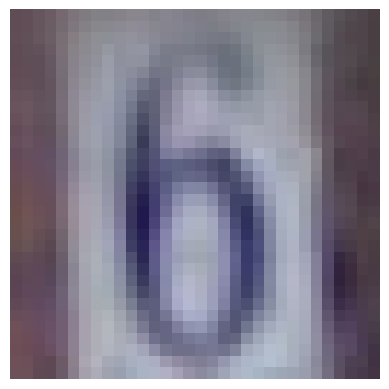

In [ ]:
# TODO :
# What is the amount of labeled and unlabeled data ?
print(f"Number of Labeled Samples: {len(dataset_train)}")
print(f"Number of Unlabeled Samples: {len(dataset_train_ul)}")

# What is in a sample ? Print the sample to understand
sample_index = 3  # Change this index as needed
sample = dataset_train[sample_index]
print("Sample Information:")
print(f"Type of Sample: {'Labeled' if dataset_train.keep_label else 'Unlabeled'}")
print(f"Sample Index: {sample_index}")
print(f"Sample Data Type: {type(sample)}")
print(f"Sample Label: {sample[1] if dataset_train.keep_label else 'No Label'}")  # Only present for labeled samples

# Plot the image in the sample.
image = sample[0] if dataset_train.keep_label else sample
imshow(image)

We start by defining a datamodule for the labeled classification.

**TODO**: Using your previous knowledge of datamodule declaration, fully define a datamodule for the **labeled data** from the previously defined Dataset `SVHN` that we will try to solve the digit classification task from.
- Your LightningDataModule should implement the following methods:
* `def setup(self, stage)`
* `def train_dataloader(self)`
* `def val_dataloader(self)`
* `def test_dataloader(self)`.


The validation data should be sampled from the training data with a ratio of 25%.

In [ ]:
class SVHNDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.data_dir = data_dir or "."
        self.batch_size = batch_size

    # TODO : As usual, complete the datamodule

    def setup(self, stage=None):
        # Define the dataset for labeled data
        labeled_dataset = SVHN(self.data_dir, split='train_labeled', download=True, label_p=0.01, transform=self.transform)

        # Split the labeled dataset into train and validation sets
        labeled_train_size = int(0.75 * len(labeled_dataset))
        labeled_val_size = len(labeled_dataset) - labeled_train_size
        self.labeled_train_dataset, self.labeled_val_dataset = random_split(labeled_dataset, [labeled_train_size, labeled_val_size])

    def train_dataloader(self):
        return DataLoader(self.labeled_train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.labeled_val_dataset, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        # Assuming you want to use the test split for evaluation
        test_dataset = SVHN(self.data_dir, split='test', download=True, transform=self.transform)
        return DataLoader(test_dataset, batch_size=self.batch_size, num_workers=4)


## 2 - SVHN Classifier from scratch

In a first time, we will directly train a classifier on the few labeled data and evaluate its accuracy on the test set.

 **<center>You are free to design the architecture of your model.</center>**

To facilitate the next sections, we will split the model into two parts:
1. **The encoder**: the succession of conv filters. Its role is to convert our images into useful representations
2. **The classifier**: an MLP which role is to predict the label given the representations

We will be using a well-known backbone for the encoder: a resnet18.

Some advices for the choice of architecture:

For the encoder sequence of nn.Conv2D filter size of 3, and stride or maxpooling

Make sure the linear size match, you can print your input size in the forward method of your model to help or use torchsummary.

In [ ]:
class SVHNEncoder(nn.Module):
    """
    Model encoder.
    """
    def __init__(self):
        super().__init__()
        self.backbone = resnet18()
        self.backbone.fc = nn.Identity()

    def forward(self, x):
        return self.backbone(x)


class SVHNClassifier(nn.Module):
    """
    Model classifier.
    """
    def __init__(self, n_class):
        super().__init__()
        # TODO : Define your classifier model (with n_class classes) here.
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),  # Adjust input size based on the output size of the ResNet18 encoder
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_class)
        )

    def forward(self, x):
        # TODO : Forward x
        x = self.classifier(x)
        return x

class SVHNModel(pl.LightningModule):
    """
    Full SVHN lightning module.
    """
    def __init__(self, n_class, lr=1e-1):
        super().__init__()
        self.encoder = SVHNEncoder() # TODO : Define your Encoder
        self.classifier = SVHNClassifier(n_class) # TODO : Define your Classifier. What is n_class ?
        self.lr = lr

    def forward(self,x):
        # TODO: Forward x
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def configure_optimizers(self):
        # TODO : Define your optimizer
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        # TODO : Define your Training Step
        # This method is pretty much similar to what your did in the MNIST classification.
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # TODO : Define your Validation Step
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        # TODO : Define your Test Step
        # What is the difference between the Training, Validation and Test Step ?
        x, y = batch
        logits = self(x)
        pred = logits.argmax(dim=1)
        acc = (pred == y).float().mean()
        self.log('test_acc', acc, on_epoch=True)


### Training

<div Align='justify'>For all the training in this lab, we will be using 'Weights & Biases' (w&b) as the logger. WandB is used in lots of companies as it provides a hassle free logging interface. It is generally more powerful and convenient to use than Tensorboard. As Tensorboard, WandB is also deployable in productions. In our case, we will use the cloud version hosted by WandB. In all of these experiments, our experiments will be logged and sent to a specific link which will be provided by WandB.</div>

Launch the Training on the `SVHNDataModule`.

In [ ]:
# TODO :
model = SVHNModel(n_class=10, lr=1e-1)
dm = SVHNDataModule(data_dir='.', batch_size=64)
logger = WandbLogger(name='SVHN_scratch',project='SVHN_classif')
trainer = pl.Trainer(accelerator="gpu",
                     max_epochs=100,
                     default_root_dir="SVHN_classification",
                     logger=logger)
trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Using downloaded and verified file: ./train_32x32.mat


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type           | Params
----------------------------------------------
0 | encoder    | SVHNEncoder    | 11.2 M
1 | classifier | SVHNClassifier | 133 K 
----------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.242    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


### Testing


In [ ]:
# TODO : Evaluate your model using the LightningModule test method.
trainer.test(model, datamodule=dm)
wandb.finish()

Using downloaded and verified file: ./train_32x32.mat


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


100%|██████████| 64275384/64275384 [00:06<00:00, 9578286.18it/s] 


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5895436406135559     │
└───────────────────────────┴───────────────────────────┘

Using downloaded and verified file: ./test_32x32.mat


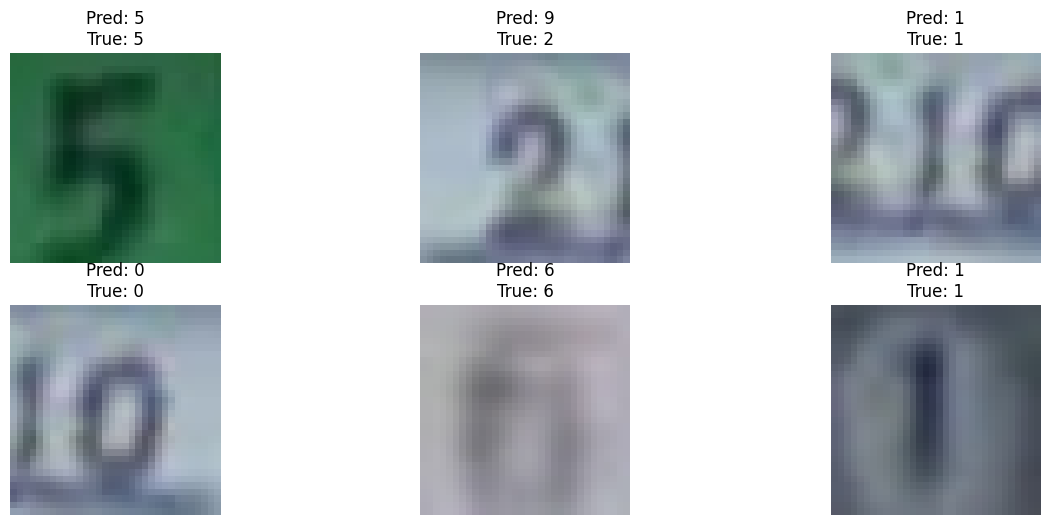

In [ ]:
# Get some test samples
test_dataloader = dm.test_dataloader()
sample_batch = next(iter(test_dataloader))
inputs, targets = sample_batch

# Make predictions
model.eval()
with torch.no_grad():
    predictions = model(inputs)

# Convert predictions and targets to numpy arrays
predictions = predictions.cpu().numpy()
targets = targets.cpu().numpy()

# Plot 10 images
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(np.moveaxis(inputs[i].numpy(), 0, -1))  # Move axis for displaying RGB images
    plt.title(f'Pred: {np.argmax(predictions[i])}\nTrue: {targets[i]}')
    plt.axis('off')

plt.show()

* Do you consider the model to be accurate ?
* Try to increase the number of epochs. What do you observe when looking at the training and validation losses ?
* Why do you think this occurs ?

## 3 - SVHN Classifier with pretext-task self-supervision

In the previous part, we have only used the labeled data for the training leaving us with too few training samples. To leverage the unlabeled data, we will now learn beforehand to solve a pretext task, and then fine-tune classification on the extracted representations. We will be using a simple pretext task: the 90° rotation recognition.

 The goal is to **classify the angle of the rotation applied on an image from {0°, 90°, 180°, 270°}.**

### i - Solving the pretext task

We will design a new datamodule that will encompass the pretext data samples with their labels from an unlabeled dataset.

* Complete the following dataset, that should be initialized from an unlabeled dataset, and provide one of the 4 rotations for each samples' image with the corresponding label.

In [ ]:
class PretextTask(Dataset):
    def __init__(self, ul_dataset):
        self.ul_dataset = ul_dataset  # ul_dataset is the unlabeled dataset
        self.num_rotations = 4  # Number of rotations: {0°, 90°, 180°, 270°}

    def __len__(self):
        return len(self.ul_dataset)

    def __getitem__(self, k):
        data_k = self.ul_dataset[k]  # Assuming ul_dataset returns only the image
        rot_k = random.choice([0, 1, 2, 3])  # Randomly choose rotation angle (0°, 90°, 180°, 270°)
        rotated_data = torch.rot90(data_k, rot_k, [1, 2])  # Apply rotation
        return rotated_data, rot_k

* Fully define a LightningDatamodule for the pretext task labeled data of the SVHN unlabeled data.

Your LightningDataModule should implement the following methods:
* `def setup(self, stage)`
* `def train_dataloader(self)`
* `def val_dataloader(self)`

(we **won't be using any test data in the pretext task**).
- The validation data should be sampled from the training data with a ratio of 20%.
- The returned dataloader should be shuffled (option `shuffle=True`).

In [ ]:
class SVHNPretextDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.data_dir = data_dir or "."
        self.batch_size = batch_size
        self.pretext_task_data = None  # Placeholder for the pretext task labeled data

    # TODO : As Usual Define the rest of this class
    def setup(self, stage=None):
        # Assuming you have an unlabeled dataset called ul_dataset
        ul_dataset = SVHN(self.data_dir, split='train_unlabeled', download=True, transform=self.transform)  # Load your unlabeled dataset

        # TODO: Create PretextTask dataset using unlabeled dataset
        pretext_task_dataset = PretextTask(ul_dataset)

        # TODO: Split the dataset for training and validation
        train_size = int(0.8 * len(pretext_task_dataset))
        val_size = len(pretext_task_dataset) - train_size
        self.pretext_task_data, _ = random_split(pretext_task_dataset, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.pretext_task_data, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.pretext_task_data, batch_size=self.batch_size, shuffle=True, num_workers=4)


**TODO**: Visualize a few images from `SVHNPretextDataModule::train_dataloader` to check your implementation (the function `imshow(img)` is provided to easily plot a tensor image or numpy image).

In [ ]:
def imshow(img, ax=None):
    if isinstance(img, torch.Tensor):
        img = np.moveaxis(img.detach().cpu().numpy(), 0, -1)

    if ax is None:
        plt.axis("off")
        plt.imshow(img)
        plt.show()
    else:
        ax.axis("off")
        ax.imshow(img)

Using downloaded and verified file: ./train_32x32.mat


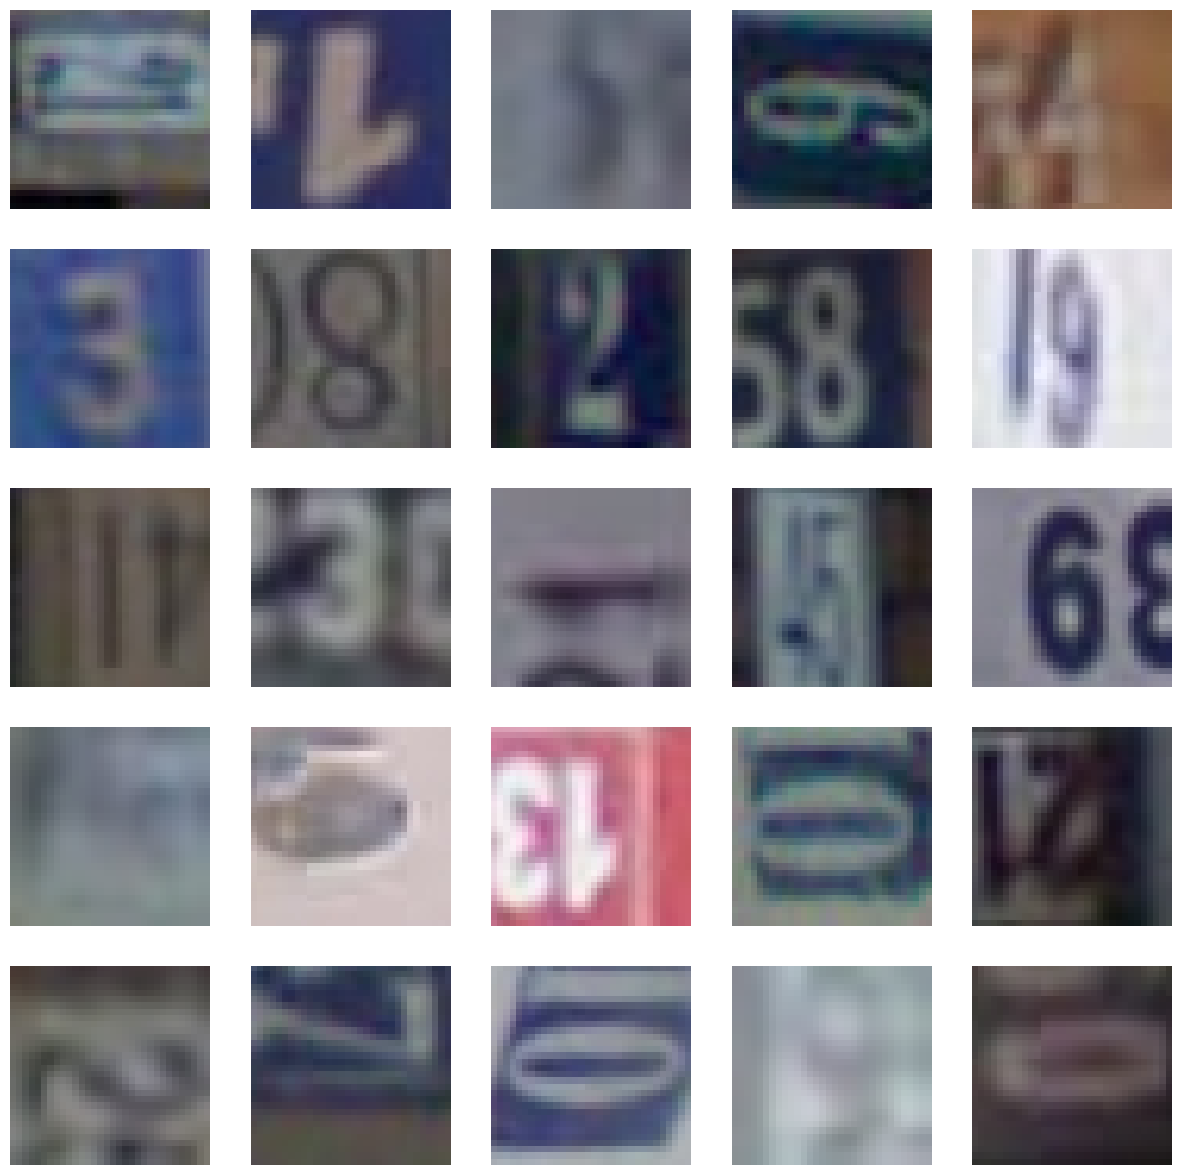

In [ ]:
dl = SVHNPretextDataModule(".", 64)
dl.setup(None)

# TODO : Plot
# Get the first batch from the train_dataloader
batch = next(iter(dl.train_dataloader()))

# Plot all images in the same figure
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# Loop through images in the batch
for i in range(min(len(batch[0]), 25)):
    row = i // 5
    col = i % 5
    imshow(batch[0][i], axs[row, col])

plt.show()


We now define our LightningModule for the pretext task learning. It is important to note that the **encoder architecture must be the same** as in the final task of digit classification. Although we are free to choose the classifier, we will reuse the SVHNClassifier class.

In [ ]:
def accuracy(preds, targets):
    """
    Compute the accuracy given the predicted and target labels.
    """
    _, predicted = torch.max(preds, 1)
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    acc = correct / total
    return acc

In [ ]:
class SVHNPretextModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # TODO : Init your Model
        self.encoder = SVHNEncoder()
        self.classifier = SVHNClassifier(n_class=4)  # 4 rotations: {0°, 90°, 180°, 270°}

    def forward(self,x):
        representation = self.encoder(x)
        logits = self.classifier(representation)
        return logits

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), 1e-2)
        return optimizer

    def training_step(self, batch, batch_idx):
        # TODO : Define your Training Step
        inputs, targets = batch
        logits = self(inputs)
        loss = F.cross_entropy(logits, targets)
        acc = accuracy(logits, targets)
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        # TODO : Define your Validation Step
        # We will also be logging our val accuracy here.
        inputs, targets = batch
        logits = self(inputs)
        loss = F.cross_entropy(logits, targets)
        acc = accuracy(logits, targets)
        self.log('val_loss', loss)
        self.log('val_acc', acc)


#### Training

Train your Model

In [ ]:
# TODO : Train
pretext_model = SVHNPretextModel()
dm = SVHNPretextDataModule(data_dir='.', batch_size=64)
logger=WandbLogger(name='SVHN_rot',project='SVHN_pretext')
trainer = pl.Trainer(accelerator="gpu",
                     max_epochs=7,
                     default_root_dir="SVHN_pretext",
                     val_check_interval=0.25,
                     logger=logger)
trainer.fit(pretext_model, dm)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Using downloaded and verified file: ./train_32x32.mat


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type           | Params
----------------------------------------------
0 | encoder    | SVHNEncoder    | 11.2 M
1 | classifier | SVHNClassifier | 132 K 
----------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.235    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


### ii - Classification fine-tunning

We will now reuse the learnt pretext task encoder as an initialization for digit classification.

#### Training

We will load the checkpoint of the pretext task encoder, and use its weights as an initialization of our final classification encoder. There are many ways to perform fine-tunning from a pretrained network; here we choose to freeze all the weights of the encoder and only train the classifier on the labeled data.

In [ ]:
# Define the SVHN classification model
class SVHNClassificationModel(pl.LightningModule):
    def __init__(self, encoder, n_class, lr=1e-3):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),  # Adjust input size based on the output size of the ResNet18 encoder
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_class)
        )
        self.lr = lr

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)
        loss = F.cross_entropy(logits, targets)
        acc = accuracy(logits, targets)
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)
        loss = F.cross_entropy(logits, targets)
        acc = accuracy(logits, targets)
        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        # TODO: Define your Test Step
        inputs, targets = batch
        logits = self(inputs)
        loss = F.cross_entropy(logits, targets)
        acc = accuracy(logits, targets)
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss



# Reload the best pretext model.
# TODO: Check that the following path matches your best pretext task training checkpoint directory.
pretext_checkpoint_dir = "/content/SVHN_pretext/l9pi5kgo/checkpoints"
best_ckpt = glob.glob(os.path.join(CONTENT_DIR, pretext_checkpoint_dir, "*.ckpt"))[0]
print("Loading checkpoint from", best_ckpt)
pretext_model = SVHNPretextModel.load_from_checkpoint(best_ckpt)
pretext_model.freeze()

# TODO: Create the SVHN classification model and use the encoder from the pretext model.
model = SVHNClassificationModel(pretext_model.encoder, n_class=10)  # Assuming 10 classes for SVHN
dm = SVHNDataModule(data_dir='.', batch_size=64)  # You need to define SVHNDataModule similar to SVHNPretextDataModule
logger = WandbLogger(name='SVHN_finetune', project='SVHN_classif')
trainer = pl.Trainer(accelerator="gpu",
                     max_epochs=150,
                     default_root_dir="SVHN_classification",
                     logger=logger)
trainer.fit(model, dm)
#wandb.finish()

Loading checkpoint from /content/SVHN_pretext/l9pi5kgo/checkpoints/epoch=6-step=6346.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Using downloaded and verified file: ./train_32x32.mat


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type        | Params
-------------------------------------------
0 | encoder    | SVHNEncoder | 11.2 M
1 | classifier | Sequential  | 133 K 
-------------------------------------------
133 K     Trainable params
11.2 M    Non-trainable params
11.3 M    Total params
45.242    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


Pytorch lightning first displays a summary of the training parameters.

* What difference do you observe by comparing it to the training from scratch ?
* Why is it so ?

### Testing

* Test some images from the testing dataset to verify that your model works.

In [ ]:
# TODO : Evaluate your model using the LightningModule test method.
trainer.test(model, datamodule=dm)
wandb.finish()

Using downloaded and verified file: ./train_32x32.mat


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using downloaded and verified file: ./test_32x32.mat


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.19383835792541504    │
│         test_loss         │     2.242230176925659     │
└───────────────────────────┴───────────────────────────┘

Using downloaded and verified file: ./test_32x32.mat


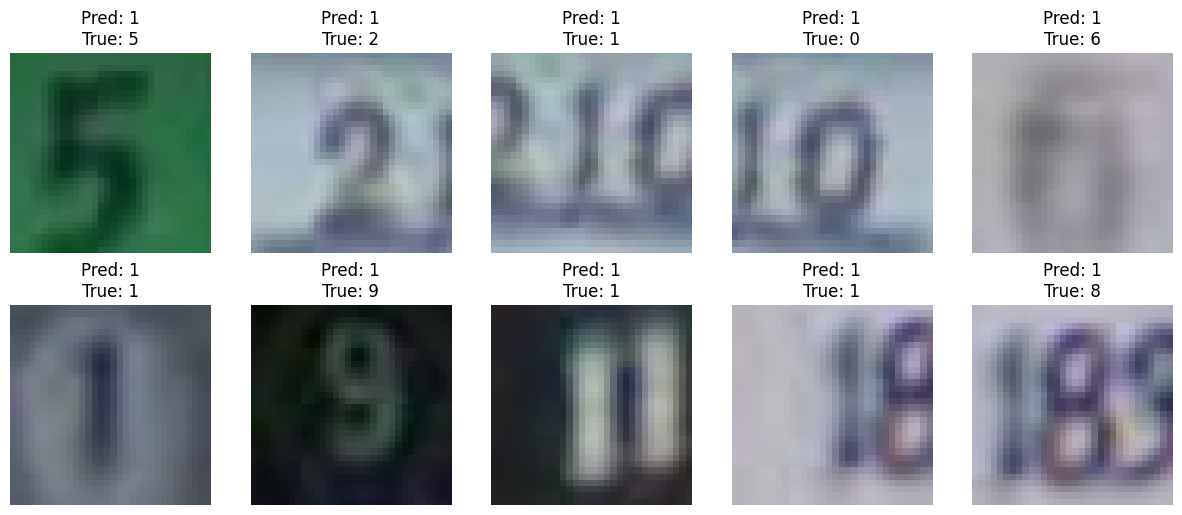

In [ ]:
# Get some test samples
test_dataloader = dm.test_dataloader()
sample_batch = next(iter(test_dataloader))
inputs, targets = sample_batch

# Make predictions
model.eval()
with torch.no_grad():
    predictions = model(inputs)

# Convert predictions and targets to numpy arrays
predictions = predictions.cpu().numpy()
targets = targets.cpu().numpy()

# Plot 10 images
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.moveaxis(inputs[i].numpy(), 0, -1))  # Move axis for displaying RGB images
    plt.title(f'Pred: {np.argmax(predictions[i])}\nTrue: {targets[i]}')
    plt.axis('off')

plt.show()

* Do you consider the model to be accurate ?
* Has the pretext task pretraining on the unlabeled data helped to improve the performance of the classifier from scratch ?

We note that for longer training times, the benefits of the self-supervised training would be more significant.

# II - Industrial Task 2 : Anomaly Detection on faces

In this last section, we will show an application of pretext tasks for anomaly detection. The main idea is that a model trained to solve a pretext task on some normal data will be less efficient on solving this task on very different data.

In particular we will learn to solve the 90° rotation detection task on the celebA dataset. The celebA dataset contains many images of celebrities which will be our normal face class samples. We have reduced the amount of samples and the size of the images to 64x64.

In [ ]:
# Download and extract CelebA dataset.
!pip install gdown
!gdown --id 1DisQMhb1fnmXGCC-JGqUTu2l7d5E1ihI
celeba_dname = os.path.join(CONTENT_DIR, "CelebA")
celeba_fname = os.path.join(CONTENT_DIR, "celebA_subset.zip")
os.makedirs(celeba_dname, exist_ok=True)
extract_archive(celeba_fname, celeba_dname)

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1DisQMhb1fnmXGCC-JGqUTu2l7d5E1ihI
To: /content/celebA_subset.zip
100% 60.3M/60.3M [00:00<00:00, 199MB/s]


'/content/CelebA'

In [ ]:
from torchvision import transforms
from PIL import Image

class CelebA(Dataset):
    def __init__(self, root, split, transform=None):
        ds_dname = os.path.join(root, "CelebA")
        if not os.path.exists(ds_dname):
            raise FileNotFoundError(ds_dname)

        self.fnames = glob.glob(os.path.join(ds_dname, {"test": "Test", "train": "Train", "valid": "Eval"}[split], "*.jpg"))
        self.transform = transform

    def __getitem__(self, k):
        fname = self.fnames[k]
        img = Image.open(fname)

        if self.transform:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.fnames)


* Perform a pretext task training on the rotation detection task with the celebA data.

You should follow the same steps as in the pretext task training on the digit data, as the training is very similar
As usual, you are free to choose the architecture and optimizer

In [ ]:
class CelebAPretextDataModule(pl.LightningDataModule):
    # TODO : Create your DataModule
    # Note that we don't have to manually split the training and validation data as the split='train' and split='valid' are defined for celebA.
    def __init__(self, data_dir, batch_size, shuffle=True):
        self.shuffle = shuffle
        ...

    def train_dataloader(self):
        return DataLoader(..., shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(..., shuffle=self.shuffle)


In [ ]:
from torch.utils.data import random_split, DataLoader
import pytorch_lightning as pl
from torchvision import transforms

class CelebAPretextDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, shuffle=True):
        super(CelebAPretextDataModule, self).__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Define data transformations
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),  # Resize images to 64x64
            transforms.RandomRotation(degrees=(0, 360)),  # Random rotation for pretext task
            transforms.ToTensor()
        ])

    def setup(self, stage=None):
        # Load CelebA dataset
        celeba_dataset = CelebA(root=self.data_dir, split='train', transform=self.transform)

        # Split the dataset into training and validation sets
        train_size = int(0.8 * len(celeba_dataset))
        val_size = len(celeba_dataset) - train_size
        self.train_dataset, self.val_dataset = random_split(celeba_dataset, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=self.shuffle)


In [ ]:
#class CelebAPretextModel(pl.LightningModule):
    # TODO : Create your LightningModule

class RotationDetector(nn.Module):
    def __init__(self):
        super(RotationDetector, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 4)  # 4 classes for 0°, 90°, 180°, 270° rotations

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16)  # Flatten before fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CelebAPretextModel(pl.LightningModule):
    def __init__(self):
        super(CelebAPretextModel, self).__init__()
        self.rotation_detector = RotationDetector()  # Assuming you have a RotationDetector module

    def forward(self, x):
        return self.rotation_detector(x)

    def training_step(self, batch, batch_idx):
        images = batch
        rotations = torch.randint(0, 4, (images.size(0),)).long()
        predictions = self(images)
        loss = F.cross_entropy(predictions, rotations)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images = batch  # Only one element in the batch, which is the image
        rotations = torch.randint(0, 4, (images.size(0),)).long()
        predictions = self(images)

        loss = F.cross_entropy(predictions, rotations)
        acc = accuracy(predictions, rotations)

        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return loss


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer


In [ ]:
# TODO : Train your model
model = CelebAPretextModel()
dm = CelebAPretextDataModule(data_dir='.', batch_size=64)
logger = WandbLogger(name='celeba',project='celeba_pretext')
trainer = pl.Trainer(accelerator="mps",
                     max_epochs=10,
                     default_root_dir="celeba_pretext",
                     logger=logger )
trainer.fit(model, dm)
wandb.finish()

MisconfigurationException: ignored

Now that our model has been trained to solve the pretext task on real faces from celebA data, we expect it to solve the task quite well. More specifically, we can expect our model to be **more accurate on solving the rotation task on faces (normal data) than on other types of data outside faces (anomalies)**.

We can thus construct a very simple anomaly detector by using the softmax score corresponding to the ground-truth as a normality score. The more confident our model is on the ground-truth, the more normal we can consider the input to be.

In [ ]:
def compute_anomaly_score(batch):
    x, y = batch
    # TODO : Compute the softmax scores using the trained CelebAPretextModel.
    soft_scores = ...
    # Take the score corresponding to the ground truth class.
    gt_soft_scores = (soft_scores*F.one_hot(y)).sum(1)
    return gt_soft_scores

We will use the CIFAR-10 dataset as the anomalous data. We now compute the anomaly scores on the normal dataset (celebA) and the anomalies (CIFAR-10).

In [ ]:
normal_dm = CelebAPretextDataModule(..., shuffle=False)
normal_dm.setup(None)

model.eval()

with torch.no_grad():
    normal_scores = []
    for batch in dm.test_dataloader():
        normal_scores.extend(compute_anomaly_score(batch).cpu().numpy())

    anomaly_scores = []
    for batch in DataLoader(CIFAR10('.', train=False, download=True, transform=transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])),
                            batch_size=32, shuffle=False):
        anomaly_scores.extend(compute_anomaly_score(batch).cpu().numpy())

normal_scores = np.array(normal_scores).reshape((-1, 4)).mean(1)
anomaly_scores = np.array(anomaly_scores).reshape((-1, 4)).mean(1)

**TODO**: Plot the ROC curve and print the AUC of the anomaly detector.

* What can you say ?